<p>Это бразильский общедоступный набор данных электронной коммерции о заказах, сделанных в магазине Olist. Набор данных содержит информацию о 100 тысячах заказов с 2016 по 2018 год, сделанных на нескольких торговых площадках в Бразилии. Его функции позволяют просматривать заказ в нескольких измерениях: от статуса заказа, цены, оплаты и доставки до местоположения клиента, атрибутов продукта.

<p>Это реальные коммерческие данные, они обезличены, а ссылки на компании и партнеров в тексте обзора заменены на названия великих домов «Игры престолов».

In [1]:
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
customers_dataset = pd.read_csv('olist_customers_dataset.csv', sep=',')

orders_dataset = pd.read_csv('olist_orders_dataset.csv', sep=',',  
                             parse_dates=['order_purchase_timestamp',
                                         'order_approved_at',
                                         'order_delivered_carrier_date',
                                         'order_delivered_customer_date',
                                         'order_estimated_delivery_date'])

order_items_dataset = pd.read_csv('olist_order_items_dataset.csv', sep=',', parse_dates=['shipping_limit_date'])

In [3]:
customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [5]:
order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


<hr>
<H3>Для начала попробуем выяснить какие записи мы можем считать покупками</H3>

In [6]:
#Есть ли заказы, где оплата была совершена уже после доставки товара?
orders_dataset.query('order_approved_at > order_delivered_customer_date').order_status.value_counts()

delivered    61
Name: order_status, dtype: int64

In [7]:
#Есть ли заказы, которые были доставлены, 
#но не оплачены (фактом доставки является заполненное значение order_delivered_customer_date)?
orders_dataset.query('order_delivered_customer_date.isna() == False and order_approved_at.isna() and (order_status != "canceled" or order_status != "unavailable")').order_status.value_counts()
#Такие заказы дают нам право считать, что работает система постоплаты с неопределенным сроком оплаты.

delivered    14
Name: order_status, dtype: int64

In [8]:
#Заказы, которые были оплачены и доставлены до двери 
orders_dataset.query('order_delivered_customer_date.isna() == False and order_approved_at.isna() == False').order_status.value_counts()

delivered    96456
canceled         6
Name: order_status, dtype: int64

<li>Видим, что есть заказы со статусом canceled. Мы не можем с точностью сказать, не было/будет ли последующей равноценной замены товаров на оплаченную сумму, что можно было расценивать как одну покупку. Т.е. мы ничего не знаем о факте возврата денег

In [9]:
#Заказы, которые оплачены, но имеют статус unavailable или canceled
orders_dataset.query('(order_status == "unavailable" or order_status == "canceled") and order_approved_at.isna() == False').order_status.value_counts()

unavailable    609
canceled       484
Name: order_status, dtype: int64

<li>Т.к. причина отмены или недоступности заказа нам не известна, а оплата была совершена, то технически такие записи можно считать покупкой. Мы не можем с точностью сказать, не было/будет ли последующей равноценной замены товаров на оплаченную сумму, что можно было расценивать как одну покупку. Т.е. мы ничего не знаем о факте возврата денег

#### Анализ выше дает мне основания полагать, что заказы с любым статусом имеют право попадать в выборку.

Потому что есть:
- Заказы, которые были доставлены до двери, но отменены. А о факте возврата денег мы ничего не знаем.
- Заказы, которые были оплачены, но имеют статус unavailable или canceled. А о факте возврата денег мы также ничего не знаем.
- Заказы, где оплата была совершена уже после доставки товара. Т.е. нет четкого срока оплаты заказа.
- Заказы, которые НЕ были оплачены, но бьли доставлены. Значит, заказчик принял заказ и исполнитель ожидает оплату. Потому что нет четкого срока оплаты заказа.

####  ВЫВОД: Считаем покупкой именно те заказы, которые либо уже оплачены, либо еще не оплачены, но уже доставлены.

In [10]:
#Запишем запрос к ДФ, что именно является ПОКУПКОЙ в переменную
query_purchase = 'order_approved_at.isna() == False or (order_approved_at.isna() and order_status == "delivered")'

<hr>
<H3>Сколько у нас пользователей, которые совершили покупку только один раз?</H3>

In [11]:
#Объединим два датафрейма, чтобы получить уникальные ИД заказчиков в соответствии с их заказами
orders_ft_customers = orders_dataset.merge(customers_dataset, left_on='customer_id', right_on='customer_id')
orders_ft_customers.shape

(99441, 12)

In [12]:
#Cмотрим сколько заказчиков сделали один заказ в принципе и запишем список заказчиков в переменную
one_order_customers = orders_ft_customers.groupby(['customer_unique_id'], as_index=False)\
                                        .agg({'order_id' : 'count'})\
                                        .rename(columns={'order_id' : 'count'})\
                                        .query('count == 1').customer_unique_id
one_order_customers.shape[0]

93099

In [13]:
#Теперь отбираем только тех заказчиков, которые сделали только один заказ, который является ПОКУПКОЙ
print('{q} пользователей, которые совершили покупку только один раз'
      .format(q=
              orders_ft_customers.query('customer_unique_id in @one_order_customers and ({query_purchase})'
                                        .format(query_purchase=query_purchase)).shape[0]))

93016 пользователей, которые совершили покупку только один раз


<hr>
<H3>Сколько заказов в месяц в среднем не доставляется по разным причинам?</H3>

ВАРИАНТЫ:
- Заказ может быть отменен и не доставлен (order_delivered_customer_date.isna() and order_status == "canceled")
- Заказ может быть не доступен (order_status == "unavailable")
- Задержка в доставке

In [14]:
#функция делает запрос к ДФ, 
#группирует по дате планируемой доставки 
#и считает среднее количество заказов в разрезе год-месяц/ср. к-во
def mean_qty_deliveried(query, title, x_label, y_label):
    df = orders_ft_customers.query(query)\
        .groupby('order_estimated_delivery_date')\
        .agg({'order_id':'count'})\
        .rename(columns={'order_id' : 'count'})\
        .sort_values(by='order_estimated_delivery_date')\
        .resample(rule='M')[['count']]\
        .mean()\
        .dropna()\
        .reset_index()
    
    df["order_estimated_delivery_date"] = df["order_estimated_delivery_date"].dt.to_period("M")
 
    plt.figure(figsize = (7,10))
    sns.barplot(data=df, y='order_estimated_delivery_date',  x='count', color='grey')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

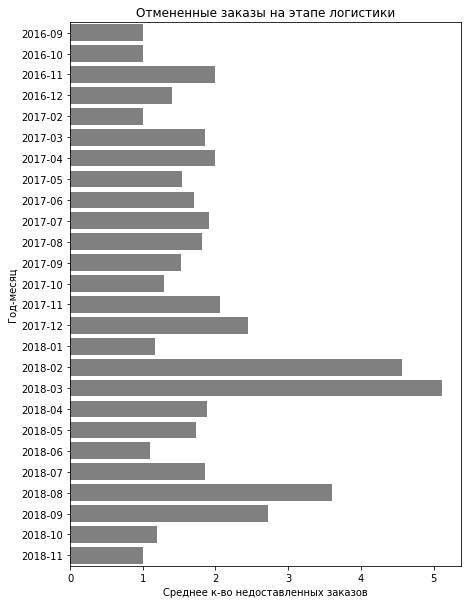

In [15]:
mean_qty_deliveried(
    'order_delivered_customer_date.isna() and order_status == "canceled"',
    'Отмененные заказы на этапе логистики',
    'Среднее к-во недоставленных заказов',
    'Год-месяц'
)

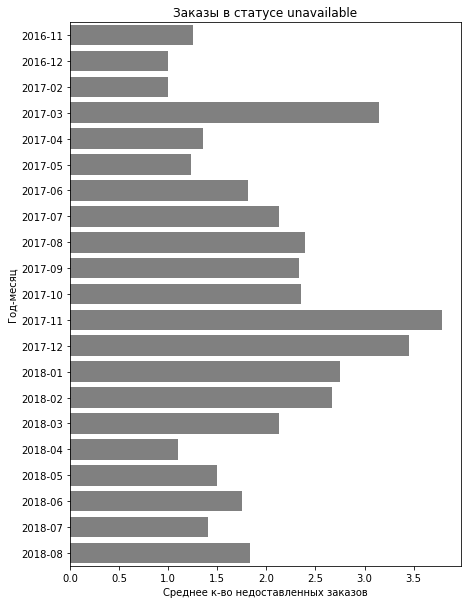

In [16]:
mean_qty_deliveried(
    'order_status == "unavailable"',
    'Заказы в статусе unavailable',
    'Среднее к-во недоставленных заказов',
    'Год-месяц'
)

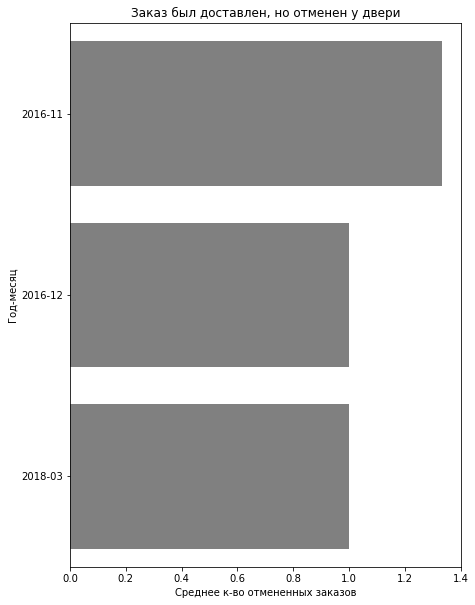

In [17]:
mean_qty_deliveried(
    'order_delivered_customer_date.isna()==False and order_status == "canceled"',
    'Заказ был доставлен, но отменен у двери',
    'Среднее к-во отмененных заказов',
    'Год-месяц'
)

<hr>
<H3>По каждому товару определим, в какой день недели товар <i>чаще</i> всего покупается, а также <i>больше</i> всего покупается.</H3>
<ul>
    <li>Дни недели, когда товар покупается ЧАЩЕ всего (независимо от количества в заказе). Считаем только факт покупки за день.</li>
    <li>Дни недели, когда товар покупается БОЛЬШЕ всего (по количеству в заказе). Считаем именно количество купленного товара по дням.</li>
</ul>

### Подготовим данные

In [18]:
#Соединим два датафрейма, чтобы получить записи с заказами и товарами
orders_ft_items = order_items_dataset.merge(orders_dataset, how='left', left_on='order_id', right_on='order_id')

#Проверим, что у нас таблицы соединились верно. Должно совпадать количество записей новой таблицы с таблицей товаров

print(orders_ft_items.shape[0] == order_items_dataset.shape[0])

True


In [19]:
query_purchase = 'order_approved_at.isna() == False or (order_approved_at.isna() and order_status == "delivered")'
#Отберем только купленные товары
purchased_items = orders_ft_items.query(query_purchase)

#Проверим к-во записей в таблицах
print('Все записи в таблице order_items_dataset =', order_items_dataset.shape[0])
print('Все записи в таблице orders_dataset =', orders_dataset.shape[0])
print('Купленные товары (orders_ft_items) =', purchased_items.shape[0])

Все записи в таблице order_items_dataset = 112650
Все записи в таблице orders_dataset = 99441
Купленные товары (orders_ft_items) = 112650


In [20]:
#Проверим к-во уникальных order_id в таблицах
print('Все уникальные order_id в таблице order_items_dataset =', order_items_dataset.order_id.nunique())
print('Все уникальные order_id в таблице orders_dataset =', orders_dataset.order_id.nunique())
print('Уникальные order_id в купленных товарах orders_ft_items =', purchased_items.order_id.nunique())

Все уникальные order_id в таблице order_items_dataset = 98666
Все уникальные order_id в таблице orders_dataset = 99441
Уникальные order_id в купленных товарах orders_ft_items = 98666


In [21]:
#уберем предупреждение от пандас
pd.options.mode.chained_assignment = None 

#создаем столбец с названием дня недели
#считаем, что датой покупки является создание товарного чека (order_purchase_timestamp)
purchased_items['weekday'] = purchased_items.order_purchase_timestamp.dt.day_name()

#создаем столбец с номером дня недели для последующей сортировки
# purchased_items['num_weekday'] = purchased_items.order_purchase_timestamp.dt.day_of_week

<hr>
<H3>Дни недели, когда товар покупается ЧАЩЕ всего (независимо от количества в заказе).</H3>

In [22]:
#возьмем только нужные колонки для отчета
items = purchased_items[['order_id', 'product_id', 'order_purchase_timestamp', 'weekday']]

#приведем столбец order_purchase_timestamp  к формату год-месяц-день, чтобы затем сгруппировать по дате без времени
items['order_purchase_timestamp'] = items.order_purchase_timestamp.dt.strftime('%Y-%m-%d')

#делаем группировку по товару и дню покупки
purchased_days_vs_items = items.groupby(['product_id', 'order_purchase_timestamp', 'weekday'], as_index=False)\
                    .agg({'order_id':'nunique'})\
                    .rename(columns={'order_id':'orders_count'})

purchased_days_vs_items.sort_values(by='orders_count', ascending=False)

,product_id,order_purchase_timestamp,weekday,orders_count
24505,422879e10f46682990de24d770e7f83d,2017-11-24,Friday,21
31479,53b36df67ebb7c41585e8d54d6772e08,2018-05-08,Tuesday,19
19832,368c6c730842d78016ad823897a372db,2017-11-24,Friday,18
31236,53759a2ecddad2bb87a079a1f1519f73,2017-11-24,Friday,16
63885,aca2eb7d00ea1a7b8ebd4e68314663af,2018-01-04,Thursday,15
...,...,...,...,...
32663,56a2556592a309ac9f087be6ca82fbf0,2017-03-06,Monday,1
32662,56a2556592a309ac9f087be6ca82fbf0,2017-03-03,Friday,1
32661,56a1efb30499b4dffd45c8d655199b11,2018-08-17,Friday,1
32660,569ffd16f8032478cbeb9800f2e94ba0,2018-08-21,Tuesday,1


In [23]:
#Делаем еще одну группировку по товару и ищем МОДУ по всем дням недели
#Лямбда функция в данном случае подсчитывает к-во строк по дням недели
mostly_purchased_items = purchased_days_vs_items.groupby('product_id', as_index=True)\
                    .weekday\
                    .agg(lambda x : x.mode()[:]).reset_index()

mostly_purchased_items.head()

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


In [24]:
#Построим сводную таблицу
pivot_mostly_purchased_items = purchased_days_vs_items.groupby(['product_id', 'weekday'], as_index=False)\
                    .agg({'orders_count' : 'count'})\
                    .pivot(index='product_id', columns='weekday', values='orders_count')\
                    .reset_index()\
                    .reindex(columns=['product_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])\
                    .sort_values(by=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

pivot_mostly_purchased_items.head(3)

weekday,product_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
20076,9c31382f02ac001fe1a33a466471d98c,1.0,1.0,1.0,1.0,1.0,1.0,1.0
32343,fb495e971326b55afcb1f473adf0afb8,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20962,a322cb898d31adbe4a4de692f4bc0276,1.0,1.0,1.0,1.0,1.0,1.0,2.0


##### Проверим, что все сделали правильно

In [25]:
mostly_purchased_items.query('product_id == "aca2eb7d00ea1a7b8ebd4e68314663af"')

,product_id,weekday
22112,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday


In [26]:
pivot_mostly_purchased_items.query('product_id == "aca2eb7d00ea1a7b8ebd4e68314663af"')

weekday,product_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
22112,aca2eb7d00ea1a7b8ebd4e68314663af,22.0,28.0,22.0,25.0,25.0,27.0,22.0


#### РЕЗУЛЬТАТ: Видим, что по отобранному ИД совпадают значения в сводной таблице и таблице дней, в которые товар чаще всего покупался

<hr>
<H3>Дни недели, когда товар покупается БОЛЬШЕ всего (по количеству в заказе).</H3>

In [27]:
#делаем группировку по товару и дню покупки
purchased_days_vs_qty_items = items.groupby(['product_id', 'order_purchase_timestamp', 'weekday'], as_index=False)\
                    .agg({'order_id':'count'})\
                    .rename(columns={'order_id':'orders_count'})

purchased_days_vs_qty_items.sort_values(by='orders_count', ascending=False)

,product_id,order_purchase_timestamp,weekday,orders_count
24505,422879e10f46682990de24d770e7f83d,2017-11-24,Friday,25
19832,368c6c730842d78016ad823897a372db,2017-11-24,Friday,23
31479,53b36df67ebb7c41585e8d54d6772e08,2018-05-08,Tuesday,21
87958,ee3d532c8a438679776d222e997606b3,2018-02-22,Thursday,21
55278,9571759451b1d780ee7c15012ea109d4,2017-08-23,Wednesday,20
...,...,...,...,...
33800,59b51733f8b660874abf04e987218962,2018-02-16,Friday,1
33799,59b51733f8b660874abf04e987218962,2018-02-06,Tuesday,1
33797,59b47581b7ba51a62bf9c3dd4fef36fd,2018-04-09,Monday,1
33796,59b47581b7ba51a62bf9c3dd4fef36fd,2018-03-19,Monday,1


In [28]:
#Делаем еще одну группировку по товару и ищем МОДУ по всем дням недели
mostly_purchased_qty_items = items.groupby('product_id', as_index=True)\
                    .weekday\
                    .agg(lambda x : x.mode()[::]).reset_index()

mostly_purchased_qty_items.head()

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


In [29]:
#Построим сводную таблицу
pivot_mostly_purchased_qty_items = purchased_days_vs_qty_items.groupby(['product_id', 'weekday'], as_index=False)\
                    .agg({'orders_count' : 'sum'})\
                    .pivot(index='product_id', columns='weekday', values='orders_count')\
                    .reset_index()\
                    .reindex(columns=['product_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])\
                    .sort_values(by=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

pivot_mostly_purchased_qty_items.head(3)

weekday,product_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
20076,9c31382f02ac001fe1a33a466471d98c,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20962,a322cb898d31adbe4a4de692f4bc0276,1.0,1.0,1.0,1.0,1.0,1.0,2.0
26696,cf28a2b7bc92809a0574cf07772c88c4,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [30]:
purchased_days_vs_qty_items.groupby(['product_id', 'weekday'], as_index=False)\
                    .agg({'orders_count' : 'sum'}).sort_values(by=['orders_count'], ascending=False)

,product_id,weekday,orders_count
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
24013,642369377615febc7fa89e4c8df5110e,Thursday,1
24018,642a40d4d73b4b2604968937de13634a,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1
24025,64315bd8c0c47303179dd2e25b579d00,Saturday,1


<AxesSubplot:title={'center':'Дни недели, в которые товары покупались ЧАЩЕ всего'}, xlabel='orders_count', ylabel='weekday'>

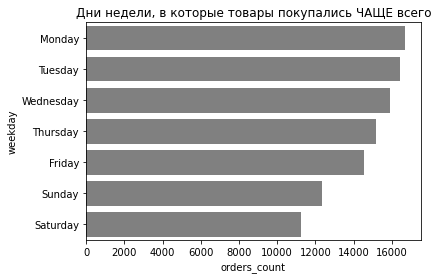

In [31]:
#Дни недели, в которые товары покупались ЧАЩЕ всего
mostly_weekday_purchases_chart = purchased_days_vs_items.groupby('weekday', as_index=False)\
                                                .agg({'orders_count' : 'sum'})\
                                                .sort_values(by='orders_count', ascending=False)

plt.title('Дни недели, в которые товары покупались ЧАЩЕ всего')
sns.barplot(data=mostly_weekday_purchases_chart, y='weekday',  x='orders_count', color='grey')

<AxesSubplot:title={'center':'Дни недели, в которые товары покупались БОЛЬШЕ всего'}, xlabel='orders_count', ylabel='weekday'>

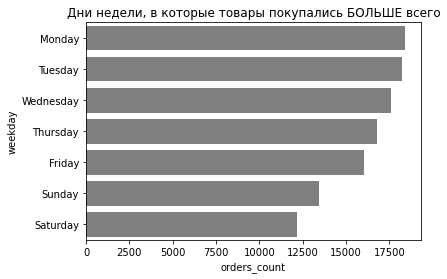

In [32]:
#Дни недели, в которые товары покупались БОЛЬШЕ всего
weekday_purchases_chart = purchased_days_vs_qty_items.groupby('weekday', as_index=False)\
                                    .agg({'orders_count' : 'sum'})\
                                    .sort_values(by='orders_count', ascending=False)

plt.title('Дни недели, в которые товары покупались БОЛЬШЕ всего')
sns.barplot(data=weekday_purchases_chart, y='weekday',  x='orders_count', color='grey')

<hr>
<H3>Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?</H3>

In [33]:
#Отберем только покупки
purchases = orders_ft_customers.query(query_purchase)

#Добавим столбцы с количеством недель и месяцем
purchases['weeks_count'] = purchases.order_purchase_timestamp.dt.daysinmonth / 7
purchases['month'] = purchases.order_purchase_timestamp.dt.strftime('%Y-%m')

customers_mean_purchases = purchases.groupby(['customer_unique_id', 'month', 'weeks_count'], as_index=False)\
    .agg({'order_id':'count'})\
    .sort_values(['customer_unique_id', 'month'])\
    .rename(columns={'order_id':'orders_per_month', 'customer_unique_id':'customer'})

customers_mean_purchases['mean_orders_per_week'] = customers_mean_purchases.orders_per_month / customers_mean_purchases.weeks_count

customers_mean_purchases[['customer', 'month', 'mean_orders_per_week']]

,customer,month,mean_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
97925,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.233333
97926,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.225806
97927,ffff371b4d645b6ecea244b27531430a,2017-02,0.250000
97928,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


<hr>
<H3>Проведем когортный анализ и посмотрим сколько пользователей к вам вернулось (retention)?</H3>

In [34]:
#создадим глобальный ДатаФрейм, объединив все три таблицы
global_df = orders_ft_items.merge(customers_dataset, on='customer_id')

#создадим таблицу для когорты
cohort_df = global_df.query(query_purchase)[['customer_unique_id', 'order_id', 'product_id', 'price', 'order_purchase_timestamp']]
cohort_df['order_purchase_timestamp'] = cohort_df.order_purchase_timestamp.dt.to_period('M')
cohort_df = cohort_df.rename(columns={'customer_unique_id' : 'customer', 'order_purchase_timestamp' : 'order_date'})\

cohort_df.head(3)

,customer,order_id,product_id,price,order_date
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,2017-09
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.9,2017-04
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.0,2018-01


In [35]:
#сгруппируем данные так, чтобы получить количество товара в соответствии с его ценой по каждому заказу
cohort_df = cohort_df.groupby(['order_id', 'customer', 'order_date', 'product_id', 'price'])\
        .agg({'price' : 'count'})\
        .rename(columns={'price' : 'qty'})\
        .reset_index()

cohort_df.head(3)

,order_id,customer,order_date,product_id,price,qty
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09,4244733e06e7ecb4970a6e2683c13e61,58.9,1
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04,e5f2d52b802189ee658865ca93d83a8f,239.9,1
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01,c777355d18b72b67abbeef9df44fd0fd,199.0,1


In [36]:
#умножим цену на количество, чтобы создать колонку total
cohort_df['total'] = cohort_df.price * cohort_df.qty
cohort_df.head(3)

,order_id,customer,order_date,product_id,price,qty,total
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09,4244733e06e7ecb4970a6e2683c13e61,58.9,1,58.9
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04,e5f2d52b802189ee658865ca93d83a8f,239.9,1,239.9
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01,c777355d18b72b67abbeef9df44fd0fd,199.0,1,199.0


In [37]:
#убедимся, что ничего не потеряли
control_sum = global_df.query(query_purchase).price.sum()

print('Сумма продаж cohort_df   =', cohort_df['total'].sum())
print('Сумма продаж control_sum =', control_sum)

Сумма продаж cohort_df   = 13591643.7
Сумма продаж control_sum = 13591643.700000003


In [38]:
cohort_df['total'].count()

102425

In [39]:
#Считаем дату первой покупки
first_orders = cohort_df.groupby('customer').agg({'order_date' : 'min'}).rename(columns={'order_date' : 'first_order'})

In [40]:
#присоединяем колонку с первыми покупками к датафрейму
cohort_df = cohort_df.merge(first_orders, how='inner', on='customer')
cohort_df.head()

,order_id,customer,order_date,product_id,price,qty,total,first_order
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09,4244733e06e7ecb4970a6e2683c13e61,58.90,1,58.90,2017-09
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04,e5f2d52b802189ee658865ca93d83a8f,239.90,1,239.90,2017-04
2,c105be01f21c9df6a2579f59b95cbcd9,eb28e67c4c0b83846050ddfb8a35d051,2017-09,d2f5484cbffe4ca766301b21ab9246dd,12.88,1,12.88,2017-04
3,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01,c777355d18b72b67abbeef9df44fd0fd,199.00,1,199.00,2018-01
4,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08,7634da152a4610f1595efa32f14722fc,12.99,1,12.99,2018-08


In [41]:
#проверим
cohort_df.groupby('first_order')['total'].agg(['sum', 'count']).sum()

sum      13591643.7
count      102425.0
dtype: float64

In [42]:
#посчитаем разность месяцев между первой покупкой и текущими покупками

#из месяца текущей покупки вычитаем месяц первой покупки
cohort_df['months_diff'] = (cohort_df['order_date'].astype('int') - cohort_df['first_order'].astype('int'))

In [43]:
#снова группируем, чтобы получить полную когорту без дубликатов по пользователям
cohort_df = cohort_df.groupby(['customer', 'order_date', 'first_order', 'months_diff'], as_index=False)\
        .agg({'total': 'sum'})

cohort_df.head()

,customer,order_date,first_order,months_diff,total
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-05,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,2018-05,0,18.90
2,0000f46a3911fa3c0805444483337064,2017-03,2017-03,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2017-10,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11,2017-11,0,180.00


In [44]:
#убедимся, что ничего не потеряли
print('Сумма продаж cohort_df   =', cohort_df.total.sum())
print('Сумма продаж control_sum =', control_sum)

Сумма продаж cohort_df   = 13591643.700000001
Сумма продаж control_sum = 13591643.700000003


In [45]:
#группируем данные по месяцу первой покупки и количеству месяцев
#считаем к-во уникальных пользователей
#отбираем для когорты только первые 12 месяцев, 
#т.е. чтобы когорта строилась только по оси y, а по оси x ограничивалась 12 месяцами
cohort_df = cohort_df.groupby(['first_order', 'months_diff'], as_index=False)\
        .agg({'customer' : 'nunique'})\
        .query('months_diff <= 12')\
        .rename(columns={'customer' : 'customers_count'})
    
cohort_df.head()

,first_order,months_diff,customers_count
0,2016-09,0,3
1,2016-10,0,305
2,2016-10,6,1
3,2016-10,9,1
4,2016-10,11,1


In [46]:
#создадим колонку размера когорты из нулевого месяца, чтобы высчитать процент по каждому месяцу
cohort_group_size = cohort_df.query('months_diff == 0')\
                                .rename(columns={'customers_count' : 'cohort_size'})\
                                [['first_order', 'cohort_size']]

cohort_df = cohort_df.merge(cohort_group_size, how='inner', on='first_order')

cohort_df['customers_count'] = cohort_df.customers_count / cohort_df.cohort_size

cohort_df.head()

,first_order,months_diff,customers_count,cohort_size
0,2016-09,0,1.000000,3
1,2016-10,0,1.000000,305
2,2016-10,6,0.003279,305
3,2016-10,9,0.003279,305
4,2016-10,11,0.003279,305


In [47]:
final_cohort = cohort_df.pivot(index='first_order', columns = 'months_diff', values = 'customers_count')
final_cohort

months_diff,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003279,NaN,NaN,0.003279,NaN,0.003279,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003979,0.002653,0.001326,0.003979,0.001326,0.003979,0.001326,0.001326,NaN,0.003979,0.001326,0.006631
2017-02,1.0,0.002346,0.002933,0.001173,0.004106,0.001173,0.002346,0.001760,0.001173,0.001760,0.001173,0.002933,0.001173
2017-03,1.0,0.005010,0.003468,0.003854,0.003468,0.001541,0.001541,0.003083,0.003468,0.000771,0.003854,0.001156,0.002312
2017-04,1.0,0.005985,0.002138,0.001710,0.003420,0.002565,0.003420,0.002993,0.002993,0.001710,0.002565,0.000855,0.000855
2017-05,1.0,0.004775,0.004775,0.003933,0.003090,0.003371,0.004213,0.001404,0.002528,0.002809,0.002528,0.003371,0.002528
2017-06,1.0,0.004817,0.003532,0.003854,0.002569,0.003854,0.003854,0.002248,0.001285,0.002248,0.003211,0.003532,0.001606


In [48]:
ur_style = (final_cohort
            .style
            .set_caption('ВНИМАНИЕ: ЕСЛИ ТАБЛИЦА НЕ ПОКРАСИЛАСЬ В ЦВЕТА, ТО НУЖНО ПЕРЕЧИТАТЬ НОУТБУК')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

ur_style

months_diff,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.33%,,,0.33%,,0.33%,
2016-12,100.00%,100.00%,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.66%
2017-02,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.18%,0.12%,0.18%,0.12%,0.29%,0.12%
2017-03,100.00%,0.50%,0.35%,0.39%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%
2017-05,100.00%,0.48%,0.48%,0.39%,0.31%,0.34%,0.42%,0.14%,0.25%,0.28%,0.25%,0.34%,0.25%
2017-06,100.00%,0.48%,0.35%,0.39%,0.26%,0.39%,0.39%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%


- Видим, что возвращаемость клиентов очень низкая на протяжении всех 12 месяцев.